In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Scaling

In [ ]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    return input_values_scaled

# Search N and H

In [ ]:
# Define the general values for N
neuron_values = [16, 32, 64, 128, 256, 512]

# Define the range for H
H_min, H_max = 2, 8

# Define the size of the population
sol_per_pop = 12
pop_size = (sol_per_pop, 3)  # We have 3 variables: N, C, fsw

# Generate random values for N and H
N_values = np.random.choice(neuron_values, size=(sol_per_pop, 1))  # Random N values
H_values = np.random.randint(H_min, H_max + 1, size=(sol_per_pop, 1))  # Random H values

# Combine N and H values into the initial population
initial_population = np.column_stack((N_values, H_values))

Epoch 1/50, Loss: 0.6507736444473267, Val Loss: 0.34034669399261475
Epoch 2/50, Loss: 0.2735920548439026, Val Loss: 0.22457605600357056
Epoch 3/50, Loss: 0.2641935646533966, Val Loss: 0.21952912211418152
Epoch 4/50, Loss: 0.2577607035636902, Val Loss: 0.21153271198272705
Epoch 5/50, Loss: 0.2414824366569519, Val Loss: 0.19230063259601593
Epoch 6/50, Loss: 0.23109005391597748, Val Loss: 0.1826029270887375
Epoch 7/50, Loss: 0.22716355323791504, Val Loss: 0.18132619559764862
Epoch 8/50, Loss: 0.22616714239120483, Val Loss: 0.1818591058254242
Epoch 9/50, Loss: 0.22642970085144043, Val Loss: 0.1833828240633011
Epoch 10/50, Loss: 0.2252930998802185, Val Loss: 0.18468883633613586
Epoch 11/50, Loss: 0.22343610227108002, Val Loss: 0.17664000391960144
Epoch 12/50, Loss: 0.22199499607086182, Val Loss: 0.17878232896327972
Epoch 13/50, Loss: 0.22213201224803925, Val Loss: 0.18523281812667847
Epoch 14/50, Loss: 0.22020818293094635, Val Loss: 0.17441442608833313
Epoch 15/50, Loss: 0.21851402521133423

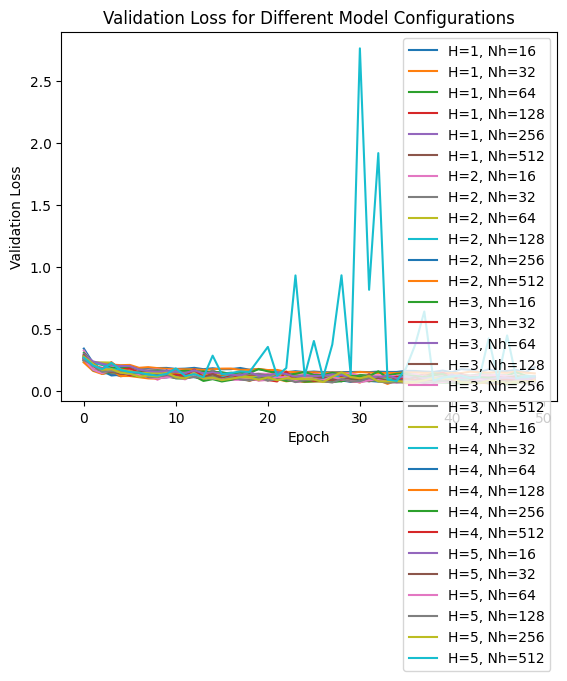

Model with H=1 and Nh=16:
MSE: 0.19215276837348938
MAE: 0.1921527698621864
RMSE: 0.4781502490306751
R-squared: 0.8020458576400746
MAPE: 18.387993400953427%
Model with H=1 and Nh=32:
MSE: 0.1432289183139801
MAE: 0.14322891385692268
RMSE: 0.41950948107692276
R-squared: 0.8978480304961818
MAPE: 13.019234936142066%
Model with H=1 and Nh=64:
MSE: 0.11908766627311707
MAE: 0.11908768468160114
RMSE: 0.36745528439096975
R-squared: 0.9354054324315806
MAPE: 9.064773689785628%
Model with H=1 and Nh=128:
MSE: 0.1118151843547821
MAE: 0.11181518357152388
RMSE: 0.3616061505684035
R-squared: 0.9452115655772548
MAPE: 8.018320727521921%
Model with H=1 and Nh=256:
MSE: 0.09583469480276108
MAE: 0.09583471987787238
RMSE: 0.2508487130835788
R-squared: 0.9586593356804745
MAPE: 6.74603406906316%
Model with H=1 and Nh=512:
MSE: 0.10851540416479111
MAE: 0.10851540461123745
RMSE: 0.2649421630329908
R-squared: 0.9549046926672843
MAPE: 7.8672416741522495%
Model with H=2 and Nh=16:
MSE: 0.12025639414787292
MAE: 0.12

In [5]:

# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter-1\simulation_results_new.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Initialize a dictionary to store the training history for each configuration
histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
# H_values = [1, 2, 3, 4, 5]  # Number of hidden layers
# Nh_values = [32, 64, 128]  # Number of neurons per hidden layer
# Additional values for H and Nh
# H_values = [1, 2, 3, 4, 5, 6, 7]  # Number of hidden layers
# Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer
H_values = [1, 2, 3, 4, 5]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512]  # Number of neurons per hidden layer



# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(3,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(6, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0, callbacks=[PrintEpochInfo()])
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


## Ranking

In [6]:
import os
import pandas as pd

# Sort configurations based on MSE in ascending order
sorted_configs_mse = sorted(mses.items(), key=lambda x: x[1])

# Sort configurations based on MAE in ascending order
sorted_configs_mae = sorted(maes.items(), key=lambda x: x[1])

# Sort configurations based on RMSE in ascending order
sorted_configs_rmse = sorted(rmses.items(), key=lambda x: x[1])

# Sort configurations based on R-squared in descending order
sorted_configs_r2 = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)

# Sort configurations based on MAPE in ascending order
sorted_configs_mape = sorted(mapes.items(), key=lambda x: x[1])

# Rank each combination based on its position in the sorted lists
ranking = {}
for i, (config, _) in enumerate(sorted_configs_mse):
    ranking[config] = i + 1

# for i, (config, _) in enumerate(sorted_configs_mae):
#     ranking.setdefault(config, 0)
#     ranking[config] += i + 1

# for i, (config, _) in enumerate(sorted_configs_rmse):
#     ranking.setdefault(config, 0)
#     ranking[config] += i + 1

# for i, (config, _) in enumerate(sorted_configs_r2):
#     ranking[config] += i + 1

# for i, (config, _) in enumerate(sorted_configs_mape):
#     ranking[config] += i + 1

# Sort configurations based on their overall ranking
sorted_ranking = sorted(ranking.items(), key=lambda x: x[1])

# Display the rankings
for rank, (config, _) in enumerate(sorted_ranking, 1):
    print(f'{rank}. Combination {config}: Overall rank {rank}')



# # Create the 'ranking' folder if it doesn't exist
# folder_path = 'ranking'
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # Create a DataFrame for the rankings
# rankings_df = pd.DataFrame(sorted_ranking, columns=['Combination', 'Overall_Rank'])

# # Define the file path for saving the CSV file
# file_path = os.path.join(folder_path, 'rankings_7.csv')

# # Save the DataFrame to a CSV file
# rankings_df.to_csv(file_path, index=False)

# print(f"Rankings saved to '{file_path}'")


1. Combination (5, 128): Overall rank 1
2. Combination (4, 256): Overall rank 2
3. Combination (5, 32): Overall rank 3
4. Combination (5, 64): Overall rank 4
5. Combination (3, 64): Overall rank 5
6. Combination (3, 512): Overall rank 6
7. Combination (2, 512): Overall rank 7
8. Combination (2, 256): Overall rank 8
9. Combination (4, 64): Overall rank 9
10. Combination (5, 256): Overall rank 10
11. Combination (3, 256): Overall rank 11
12. Combination (3, 128): Overall rank 12
13. Combination (4, 32): Overall rank 13
14. Combination (1, 256): Overall rank 14
15. Combination (2, 128): Overall rank 15
16. Combination (4, 16): Overall rank 16
17. Combination (2, 64): Overall rank 17
18. Combination (4, 128): Overall rank 18
19. Combination (2, 32): Overall rank 19
20. Combination (3, 32): Overall rank 20
21. Combination (1, 512): Overall rank 21
22. Combination (5, 16): Overall rank 22
23. Combination (1, 128): Overall rank 23
24. Combination (3, 16): Overall rank 24
25. Combination (1, 6

## Try spesific N and H

In [7]:
# Specify the combination you want to call
H = 5
Nh = 128

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model

# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

127/127 [==============================] - 0s 631us/step
Predictions:
[[2.87525766e-02 7.79247284e-01 3.09456277e+00 3.10579586e+00
  1.89681705e-02 2.11162758e+00]
 [4.46155310e+00 4.47152567e+00 2.23543242e-01 2.55223083e+00
  1.68272983e-02 2.76224017e-01]
 [1.43909767e-01 8.85467815e+00 3.53712511e+00 3.51360083e+00
  6.86740503e-03 1.18036652e+00]
 [7.30786398e-02 1.11405528e+00 3.52360392e+00 3.53932023e+00
  2.15347204e-02 9.64191377e-01]
 [2.64830850e-02 1.22409534e+00 3.37325144e+00 3.38549471e+00
  1.34525625e-02 2.09442711e+00]]
True Values:
[[3.73126122e-02 7.47245981e-01 3.03643319e+00 3.03643319e+00
  1.72160434e-02 2.15202491e+00]
 [9.49393284e-01 4.47959053e+00 1.85248205e+00 1.85248205e+00
  7.27748221e-02 1.05888718e+00]
 [1.82801723e-01 9.05225544e+00 3.44051329e+00 3.44051329e+00
  6.14689682e-03 1.17069267e+00]
 [7.21944866e-02 1.01012118e+00 3.53549404e+00 3.53549404e+00
  2.30594268e-02 9.72148356e-01]
 [2.94638994e-02 1.12389005e+00 3.32770238e+00 3.32770238e+00

# Machine Learning

Epoch 1/50
175/175 [==============================] - 1s 2ms/step - loss: 1.2312 - val_loss: 1.8220
Epoch 2/50
175/175 [==============================] - 0s 1ms/step - loss: 0.7014 - val_loss: 0.9146
Epoch 3/50
175/175 [==============================] - 0s 1ms/step - loss: 0.5161 - val_loss: 0.4631
Epoch 4/50
175/175 [==============================] - 0s 1ms/step - loss: 0.4439 - val_loss: 0.3551
Epoch 5/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3981 - val_loss: 0.2742
Epoch 6/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3696 - val_loss: 0.2336
Epoch 7/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3615 - val_loss: 0.2677
Epoch 8/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3536 - val_loss: 0.2804
Epoch 9/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3828 - val_loss: 0.2224
Epoch 10/50
175/175 [==============================] - 0s 1ms/step - loss: 0.3367 - val_loss: 0.2040

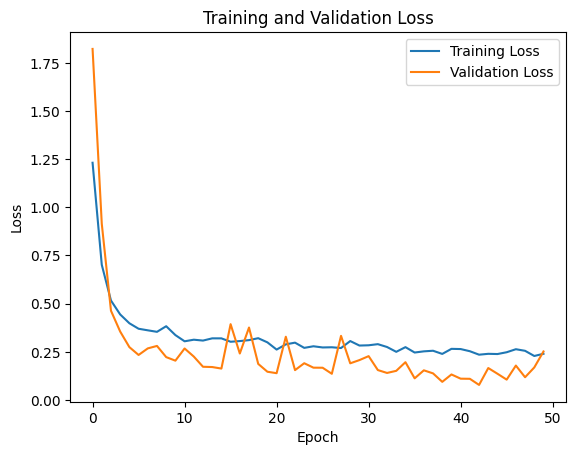

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(128, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
])

# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
# ])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo()], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Set

In [7]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

38/38 [==============================] - 0s 606us/step - loss: 0.1632
Mean Squared Error on Testing Set: 0.16320562362670898
38/38 [==============================] - 0s 499us/step
Predictions:
[[0.20654827 6.483947   2.6345077  2.6322153  0.01708872 1.3133281 ]
 [0.12445674 4.282261   3.5189834  3.520649   0.00829306 1.0214925 ]
 [0.14707306 6.546033   3.3875675  3.4100778  0.00850959 1.2893308 ]
 [0.06795892 4.3753366  2.3814638  2.3742485  0.01889426 2.3163981 ]
 [0.06067272 0.20301414 2.079679   2.104424   0.14704187 2.053334  ]]
True Values:
[[0.26001435 4.23264405 2.74299141 2.74299141 0.01217656 1.29224261]
 [0.19503469 3.32206237 3.59940991 3.59940991 0.00902757 0.95760415]
 [0.23933468 4.23420079 3.51435724 3.51435724 0.00733677 1.291914  ]
 [0.08042573 4.24613856 2.40471154 2.40471154 0.02217949 2.34150863]
 [0.07897327 0.58997409 2.02413572 2.02413572 0.16765618 2.15456352]]
Mean Absolute Error (MAE): 0.13914263041641098
Root Mean Squared Error (RMSE): 0.4039871578126952
R-sq

## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")


In [5]:
import numpy as np

# Define the general values for N
neuron_values = [16, 32, 64, 128, 256, 512]

# Define the range for H
H_min, H_max = 2, 8

# Define the size of the population
sol_per_pop = 12
pop_size = (sol_per_pop, 3)  # We have 3 variables: N, C, fsw

# Generate random values for N and H
N_values = np.random.choice(neuron_values, size=(sol_per_pop, 1))  # Random N values
H_values = np.random.randint(H_min, H_max + 1, size=(sol_per_pop, 1))  # Random H values

# Combine N and H values into the initial population
initial_population = np.column_stack((N_values, H_values))

print("Initial Population (before replacing):")
print(initial_population)

# Now let's say you generate new N and H values
# For demonstration, I'm just regenerating the same values, but in practice, these would be generated differently
new_N_values = np.random.choice(neuron_values, size=(sol_per_pop, 1))  # New random N values
new_H_values = np.random.randint(H_min, H_max + 1, size=(sol_per_pop, 1))  # New random H values

# Replace the existing N and H values in the initial population with the new ones
initial_population[:, :2] = np.column_stack((new_N_values, new_H_values))

print("\nInitial Population (after replacing N and H):")
print(initial_population)


Initial Population (before replacing):
[[ 32   6]
 [128   6]
 [ 64   2]
 [512   8]
 [ 16   2]
 [128   8]
 [ 64   8]
 [256   5]
 [ 64   3]
 [ 64   7]
 [ 16   6]
 [512   7]]

Initial Population (after replacing N and H):
[[ 16   6]
 [128   5]
 [ 32   5]
 [ 16   7]
 [ 16   2]
 [512   4]
 [ 64   5]
 [ 32   8]
 [ 16   2]
 [128   3]
 [512   4]
 [256   3]]


In [7]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    return input_values_scaled

In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error


# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter-1\simulation_results_new.csv")


# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Apply custom scaling
X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Assuming you have already defined your machine learning model and dataset
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

def compute_fitness(N, H):
    # Define the model architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))  # Scalarization layer
    
    # Add hidden layers
    for _ in range(H):
        model.add(tf.keras.layers.Dense(N, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(6, activation='softplus'))  # Output layer with 6 neurons
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # Train the model with given hyperparameters
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
    # Evaluate the model on validation data to compute the fitness value
    y_val_pred = model.predict(X_val)
    val_loss = mean_squared_error(y_val, y_val_pred)
    
    # Fitness value is the inverse of the validation loss (lower loss is better)
    fitness = 1 / (val_loss + 1e-10)  # Adding a small value to prevent division by zero
    
    return fitness

# Example initial population
initial_population = np.array([[32, 2],
                               [64, 3],
                               [128, 4]])

# Compute fitness values for each individual in the initial population
fitness_values = np.zeros(initial_population.shape[0])
for i in range(initial_population.shape[0]):
    N = initial_population[i, 0]
    H = initial_population[i, 1]
    fitness_values[i] = compute_fitness(N, H)

print("Fitness Values:")
print(fitness_values)


NameError: name 'X_train' is not defined